In [2]:
import matplotlib.pyplot as plt
import jax.numpy as np
import utils.metric as metric
from utils import set_plot, add_boolean_argument
from utils.hdf_io import load_hdf_file
from DeepSPDE import LMatrixGenerator, Fourier, RandomGenerator
from utils.loss_function_and_support import dod_non_analytical_mean_and_std as non_analytical_mean_and_std

In [11]:
fig_size, lw, marker_size = set_plot(use_latex=True)
lw = 3*lw

In [4]:
adam_smooth_file_name_str = "30_01_2021_15_50_00_SMOOTH_DISCONTINUOUS_n_prior_layers1.hdf"
adam_rect_file_name_str = "30_01_2021_15_53_38_RECT_n_prior_layers1.hdf"
# adahessian_smooth_file_name_str = "28_01_2021_20_51_20_SMOOTH_DISCONTINUOUS_n_prior_layers1.hdf"
# adahessian_rect_file_name_str = "28_01_2021_20_47_48_RECT_n_prior_layers1.hdf"
adahessian_smooth_file_name_str = "31_01_2021_15_13_02_SMOOTH_DISCONTINUOUS_n_prior_layers1.hdf"
adahessian_rect_file_name_str = "31_01_2021_15_13_03_RECT_n_prior_layers1.hdf"
rmsprop_smooth_file_name_strooth_file_name_str = "27_01_2021_15_58_25_SMOOTH_DISCONTINUOUS_n_prior_layers1.hdf"
rmsprop_rect_file_name_str = "27_01_2021_15_58_58_RECT_n_prior_layers1.hdf"

In [5]:
relative_path: str = './.simulation_results'
simulation_index: int = 47
redo_statistics: bool = False
use_lancos: bool = True

In [6]:
smooth_file_names = [adam_smooth_file_name_str,adahessian_smooth_file_name_str,rmsprop_smooth_file_name_strooth_file_name_str]
rect_file_names = [adam_rect_file_name_str,adahessian_rect_file_name_str,rmsprop_rect_file_name_str]
colors = ['b','r','g']

In [7]:
data_set_names = ['end_state_all', 'sigmas', 'h_matrix', 'normalized_meas_samples', 'kappa0', 'use_soft_max',
                  'fourier_basis_number', 'fourier_target_number', 'meas_samples', 'n_prior_layers',
                  '/dod/_DenoisingOneD__t', '/dod/_DenoisingOneD__ground_truth_signal',
                  '/dod/_DenoisingOneD__num_points', 'loss_val_all', '/optimizer/_name_','/signal_shape/_name_']
array_names = ['end_state_all', 'sigmas', 'h_matrix', 'normalized_meas_samples', 'kappa0', 'use_soft_max',
               'fourier_basis_number', 'fourier_target_number', 'meas_samples', 'n_prior_layers',
               't', 'ground_truth_signal', 'num_points', 'loss_val_all', 'optimizer_name', 'signal_shape']

In [14]:
necessary_variables_created = False
optimizer_name_list = []
v_mean_list = []
v_std_list = []
kappa_list = []
file_name_list = rect_file_names
for file_name in file_name_list:
    var_ = load_hdf_file(file_name, relative_path, data_set_names, array_names)
    if not necessary_variables_created:
        f = Fourier(var_['fourier_basis_number'], var_['fourier_target_number'], 1)
        rg = RandomGenerator(f.basis_number, f.dimension)
        n_samples = var_['normalized_meas_samples'].shape[0]
        num_points = var_['num_points']
        sigmas = var_['sigmas']
        y = var_['normalized_meas_samples'][simulation_index]
        h_matrix = var_['h_matrix']
        necessary_variables_created = True
    
    if var_['use_soft_max']:
        kappa_fun = lambda x: np.log(np.exp(x) + 1)
        l_matrix = LMatrixGenerator(f, var_['kappa0'], kappa_fun=kappa_fun)
    else:
        l_matrix = LMatrixGenerator(f, var_['kappa0'])
    if var_['end_state_all'].dtype == np.float32:
        n_prior_layers = var_['n_prior_layers']
        end_state_all = var_['end_state_all']
        whalfs_shape = (end_state_all.shape[0], 2, n_prior_layers, f.basis_number)
        state_real_shaped = end_state_all.reshape(whalfs_shape)
        state_real_shaped = np.swapaxes(state_real_shaped, 0, 1)
        var_['end_state_all'] = state_real_shaped[0] + 1j * state_real_shaped[1]
        
    w_halfs = var_['end_state_all'][simulation_index]    
    v_mean, v_std = non_analytical_mean_and_std(w_halfs, sigmas, h_matrix, y, n_samples, l_matrix, num_points,
                                                f, rg, use_lancos=use_lancos)
    kappa = l_matrix.kappa_fun(f.irfft(l_matrix.u_half_min_1))
    optimizer_name_list.append(var_['optimizer_name'])
    v_mean_list.append(v_mean)
    v_std_list.append(v_std)
    kappa_list.append(kappa)
    
if v_mean_list:
    v_mean_all = np.stack(v_mean_list)
else:
    v_mean_all = np.nan

if v_std_list:
    v_std_all = np.stack(v_std_list)
else:
    v_std_all = np.nan

if kappa_list:
    kappa_all = np.stack(kappa_list)
else:
    kappa_all = np.nan
    


In [9]:
t = np.linspace(0, 1., var_['num_points'], dtype=np.float32)

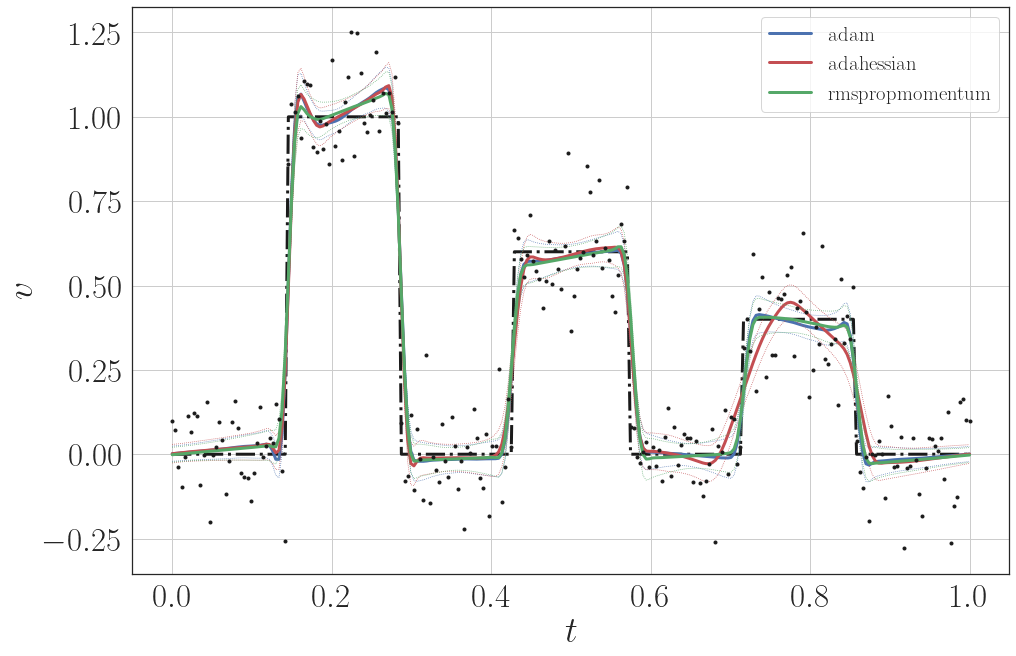

In [15]:
plt.figure(figsize=fig_size)
plt.plot(t, var_['ground_truth_signal'], '-.k', linewidth=lw)
for i in range(len(optimizer_name_list)):
    v_mean = v_mean_all[i]
    v_std = v_std_all[i]
    optimizer = optimizer_name_list[i].lower().replace('_','')
    plt.plot(t, v_mean + 2 * v_std, color=colors[i],linestyle=':', linewidth=0.25*lw)
    plt.plot(t, v_mean - 2 * v_std, color=colors[i],linestyle=':', linewidth=0.25*lw)
    plt.plot(t, v_mean, color=colors[i],linestyle='-', linewidth=lw, label=optimizer)
    
plt.plot(t, var_['meas_samples'][simulation_index], '.k', markersize=marker_size, linewidth=lw)
plt.grid()
plt.legend(loc='best',fontsize='xx-small')
plt.ylabel('$v$')
plt.xlabel('$t$')
plt.tight_layout()
# plt.savefig('./.plots/v_{}_comparison.pdf'.format(var_['signal_shape']))
# plt.close()

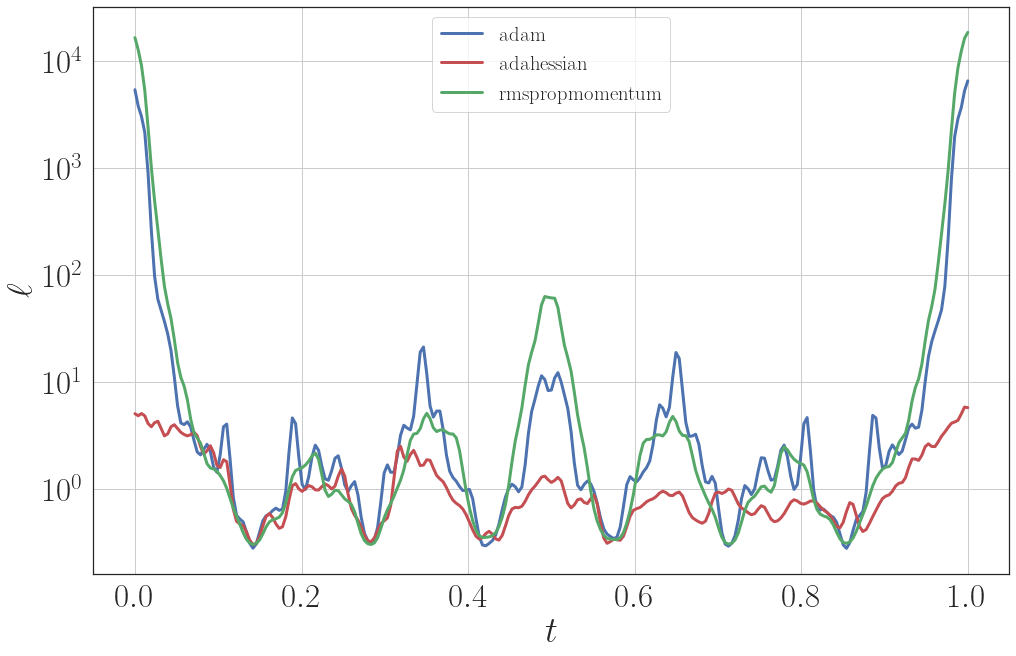

In [16]:
plt.figure(figsize=fig_size)
for i in range(len(optimizer_name_list)):
    kappa = kappa_all[i]
    optimizer = optimizer_name_list[i].lower().replace('_','')
    plt.semilogy(t, np.flip(1 / kappa), color=colors[i],linestyle='-', linewidth=lw, label=optimizer)  
plt.grid()
plt.legend(loc='best',fontsize='xx-small')
plt.ylabel('$\ell$')
plt.xlabel('$t$')
plt.tight_layout()
# plt.savefig('./.plots/ell_{}_comparison.pdf'.format(var_['signal_shape']))
# plt.close()